this notebook outlines the basics on opening h5 files, segmenting them up and viewing images.

In [53]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
#from IPython.display import display #
#import cv2 # not working
import os

In [54]:
ds_loc = '/home/users/esree/data/2ds/' ## note this is just 1 channel # Export_base220622110532.h5 -> 1 file within this
hvps_loc = '/home/users/esree/data/hvps/'

file_list = glob(ds_loc+'Export_base*.h5') # whole string of path + filenames in location
file_names = [os.path.basename(file_path) for file_path in file_list] # just file names

file_name = 'Export_base220723153010.h5' # example file

## basic code
* opening h5 file
* extracting the 2 parts of data in a h5 file (image data / time data are seperate)
* making time into xarray + make cumulative time slices
* extract and view 1 crystal image

In [55]:
f2ds = h5py.File(ds_loc+ file_name,'r') #22 06 22 11 05 32 -> yy mm dd hh mm ss

In [56]:
# what is the structure of 1 file?
#list(f2ds.keys()) ## ['ImageData', 'ImageTimes']

ds_image = f2ds['ImageData'] # shape (128, 200000) --> 128 pixels width, 200000 length
ds_time = f2ds['ImageTimes'] # shape (100000, 3) --> (rows, columns) related to time

# make time variable -> 3 seperate columns
og_t_xr = xr.Dataset({'ImageTimes': (('data', 'time_vars'),ds_time)})
sec_since = og_t_xr['ImageTimes'][:,0] # seconds since midnight UTC
pixel_slice = og_t_xr['ImageTimes'][:,1] # number of slices of pixel per image (contain -1, to fill)
# we can use pixel slice to correcly divide up data
bit_time = og_t_xr['ImageTimes'][:,2] # 32 bit (instrument things) - not useful
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# do cumulative sum of pixel slices -> can use this as index to slice + extract single crystals
pix_sum = pixel_slice.cumsum(dim='data', dtype ='int')

# shove together into a useful xarray 
time_xr = xr.Dataset({
    'sec_since': sec_since,
    'pixel_slice': pixel_slice,
    #'bit_time': bit_time,
    'pix_sum': pix_sum})

## e.g. 1 crystal index -> time_xr['pixel_slice'][0:1] or time_xr['pixel_slice'][20:21] etc

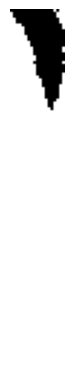

In [68]:
## as the image is a 2D array, we can view it in matplotlib <3
i = 28
im_s_idx = int(time_xr['pix_sum'][i])
im_e_idx = int(time_xr['pix_sum'][i+1])

one_crystal = f2ds['ImageData'][:,im_s_idx:im_e_idx] # extract 1 crystal

plt.imshow(one_crystal, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

## other essential bits
* convert the `'Export_base220723153010.h5'` string to a usuable datetime
* using this correct date to fix seconds since midnight

In [78]:
## this is just fixing 1 file name
date_str = file_name[11:17]
time_str = file_name[17:25]

starting_date = datetime.strptime(date_str, '%y%m%d')

time_deltas = [timedelta(seconds=float(sec)) for sec in time_xr['sec_since']]
datetimes = [starting_date + delta for delta in time_deltas]

utc_time = xr.DataArray(datetimes, dims='data', name='utc_time')
# add this to existing time array
time_xr['utc_time'] = utc_time

### not very useful bits of code
cutting out images that are 1 pixel in width in pix_sum
displaying rows / colummns of these images

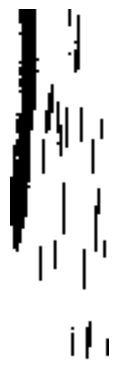

In [28]:
diff = np.diff(time_xr['pix_sum'][:].values) # this is finding the difference between each 
selected_values = time_xr['pix_sum'][:-1][diff > 1] # this is selecting the adjacent files in which have pixels > 1 length

i = 1
im_s_idx = int(selected_values[i])
im_e_idx = int(selected_values[i+1])

one_crystal = f2ds['ImageData'][:,im_s_idx:im_e_idx] # extract 1 crystal

plt.imshow(one_crystal, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

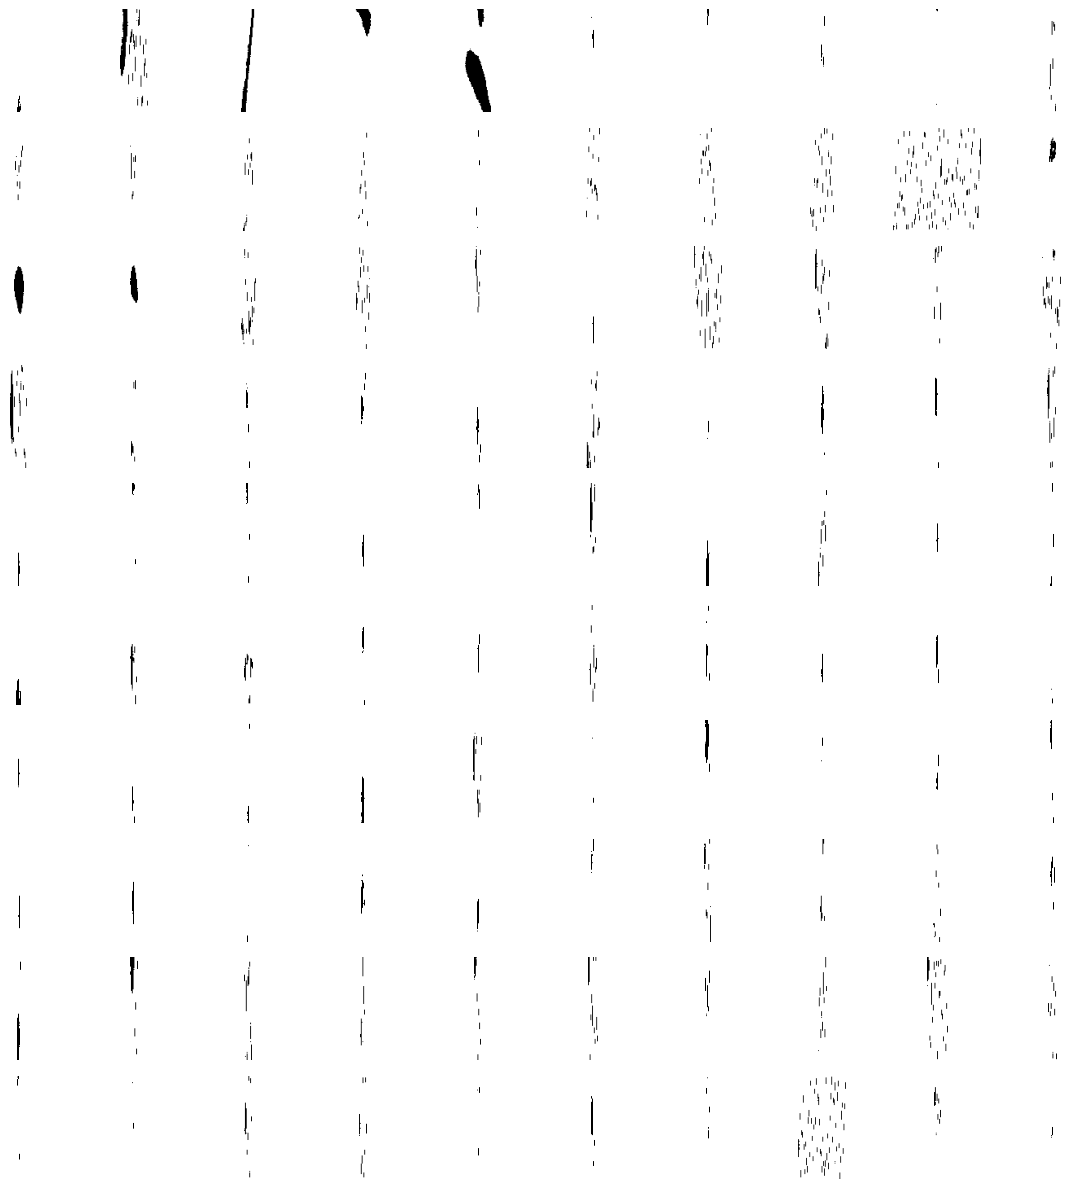

In [46]:
num_rows = 10
num_cols = 10

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i in range(num_rows):
    for j in range(num_cols):
        # Calculate the subplot index
        index = i * num_cols + j + 1
        ax = axes[i, j]
        ax.imshow(f2ds['ImageData'][:,int(selected_values[index-1]):int(selected_values[index])], cmap = 'gray')  # Example plot
        ax.axis('off')
        
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
## want to look at some time values:
## make sure it has correct variables in it
data_subset = time_xr.isel(utc_time=slice(0, 100), pixel_slice=slice(0, 100), pix_sum =slice(0, 100))

# Convert the subset to a pandas DataFrame
'''
df = data_subset.to_dataframe().to_csv('time_xr.csv')

df = time_xr.to_dataframe().to_csv('old_time.csv')
'''